In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functions import basic
from functions import interaction
from functions import evolution
import main
%matplotlib inline

In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
# reading input file
filename = "fcc100a256.txt"
lattice = basic.read_file(filename)

In [5]:
# computing ditances, finding neighbours

# no PBC test
start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice)
print(f'no PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice, PBC=True)
print(f'PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

no PBC - 100 iterations; computing time: 0.59 seconds
PBC - 100 iterations; computing time: 0.57 seconds


In [7]:
# calculating potential energy
mask,distances = basic.find_neighbours(*lattice)

# approximate LJ
start = time.process_time()
for i in range(100):
    LJA = interaction.lennard_jones_approx(distances)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# true LJ
start = time.process_time()
for i in range(100):
    LJ = interaction.lennard_jones(distances)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ: {LJA:.2f}')
print(f'true LJ: {LJ:.2f}')

approximate LJ - 100 iterations; computing time: 0.71 seconds
true LJ - 100 iterations; computing time: 0.81 seconds

approximate LJ: -453.45
true LJ: -532.48


In [9]:
# calculating forces

# approximate LJ
start = time.process_time()
for i in range(100):
    FxA,FyA,FzA = interaction.calc_force_approx(*lattice,distances,PBC=True)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# approximate LJ
start = time.process_time()
for i in range(100):
    Fx,Fy,Fz = interaction.calc_force(*lattice,distances,PBC=True)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ, force on 0-th atom: {FxA[1]:.2f},{FyA[1]:.2f},{FzA[1]:.2f}')
print(f'true LJ, force on 0-th atom: {Fx[1]:.2f},{Fy[1]:.2f},{Fz[1]:.2f}')

approximate LJ - 100 iterations; computing time: 2.59 seconds
true LJ - 100 iterations; computing time: 3.00 seconds

approximate LJ, force on 0-th atom: 0.00,0.00,-0.11
true LJ, force on 0-th atom: 0.00,0.00,0.37


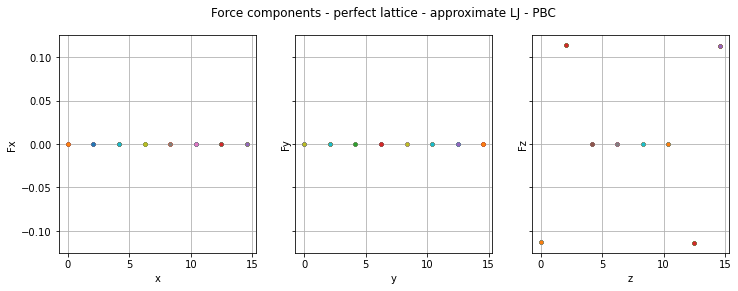

In [10]:
n_atoms,sx,sy,sz,x,y,z = lattice

fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

for i in range(255):
    axs[0].plot(x[i],FxA[i],'.')
    axs[1].plot(y[i],FyA[i],'.')
    axs[2].plot(z[i],FzA[i],'.')

for i in range(3):
    axs[i].grid()

axs[0].set_xlabel('x')
axs[0].set_ylabel('Fx')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Fy')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Fz')

fig.suptitle('Force components - perfect lattice - approximate LJ - PBC')
plt.show()

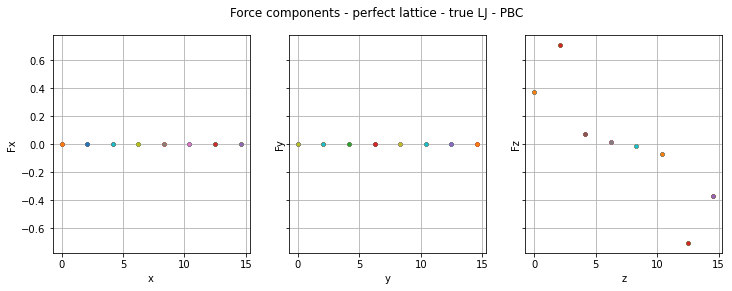

In [11]:
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

for i in range(255):
    axs[0].plot(x[i],Fx[i],'.')
    axs[1].plot(y[i],Fy[i],'.')
    axs[2].plot(z[i],Fz[i],'.')

for i in range(3):
    axs[i].grid()

axs[0].set_xlabel('x')
axs[0].set_ylabel('Fx')
axs[1].set_xlabel('y')
axs[1].set_ylabel('Fy')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Fz')

fig.suptitle('Force components - perfect lattice - true LJ - PBC')
plt.show()

In [12]:
# initializing speed
m_ag = 108*1.66e-27/16
kb = 1/11603
T = 100

start = time.process_time()
vx,vy,vz = basic.initialize_speed(n_atoms,x,y,z,T,remove_translation=True)
print(f'speed initialization; computing time: {time.process_time() - start :.3f} seconds\n')

v2 = vx**2 + vy**2  + vz**2
Ekin = 0.5*m_ag*np.sum(v2)
Tkin = 2*Ekin/(3*n_atoms*kb)  

print('translation removal check:')
print(f'    mean vx: {np.mean(vx)}')
print(f'    mean vy: {np.mean(vy)}')
print(f'    mean vz: {np.mean(vz)}\n')
print(f'Set temperature: {T:.2f}K; real temperature: {Tkin:.2f}K')

speed initialization; computing time: 0.001 seconds

translation removal check:
    mean vx: -0.000152587890625
    mean vy: 0.00010204315185546875
    mean vz: 8.392333984375e-05

Set temperature: 100.00K; real temperature: 100.00K


### Full simulation using built-in function

#### No PBC, no approx

In [28]:
filename = "fcc100a256.txt"
timelength = 40e-12    
timestep = 2.5e-14   
T = 100

results = main.make_simulation(filename,T,timelength,timestep)
time_array,all_x,all_y,all_z,Temp_array,energy_array = results

Translation removal check:
    mean vx: 5.91278076171875e-05
    mean vy: 1.430511474609375e-05
    mean vz: 0.0001659393310546875

Set temperature: 100.00K; real temperature: 100.00K 



  0%|          | 0/1599 [00:00<?, ?it/s]

In [29]:
np.std(energy_array[400:])/np.mean(energy_array[400:])

-6.880907895215755e-05

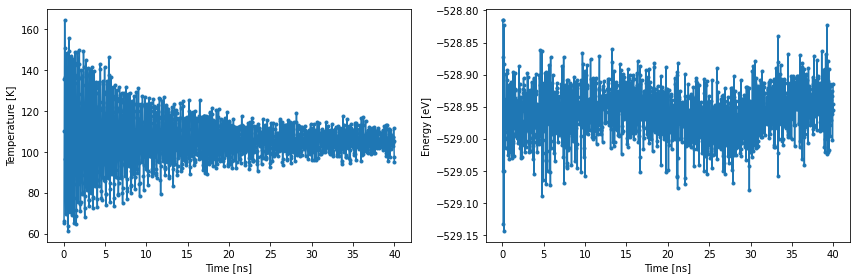

In [30]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(time_array*1e12,Temp_array,'.-')
axs[1].plot(time_array*1e12,energy_array,'.-')

for ax in axs:
    ax.set_xlabel('Time [ns]')

axs[0].set_ylabel('Temperature [K]')
axs[1].set_ylabel('Energy [eV]')

fig.tight_layout()

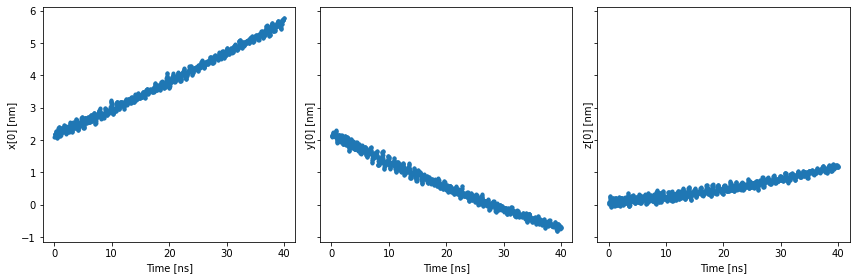

In [31]:
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

axs[0].plot(time_array*1e12,all_x[0],'.-')
axs[1].plot(time_array*1e12,all_y[0],'.-')
axs[2].plot(time_array*1e12,all_z[0],'.-')

for ax in axs:
    ax.set_xlabel('Time [ns]')
    
axs[0].set_ylabel('x[0] [nm]')
axs[1].set_ylabel('y[0] [nm]')
axs[2].set_ylabel('z[0] [nm]')

fig.tight_layout()

#### PBC, approx

In [32]:
filename = "fcc100a256.txt"
timelength = 40e-12    
timestep = 2.5e-14   
T = 100

results = main.make_simulation(filename,T,timelength,timestep,PBC=True,approx=True)
time_array,all_x,all_y,all_z,Temp_array,energy_array = results

Translation removal check:
    mean vx: 0.0001316070556640625
    mean vy: 0.0001468658447265625
    mean vz: 0.000152587890625

Set temperature: 100.00K; real temperature: 100.00K 



/home/demetrio/git_repo/molecular_dynamics/functions/interaction.py:89: RuntimeWarning: invalid value encountered in multiply
  Fx_rp = 24*epsilon*( 2*sigma**12*(mask_rp*distances)**(-14) - sigma**6*(mask_rp*distances)**(-8) )*(mask_rp*x_distances)
/home/demetrio/git_repo/molecular_dynamics/functions/interaction.py:89: RuntimeWarning: divide by zero encountered in power
  Fx_rp = 24*epsilon*( 2*sigma**12*(mask_rp*distances)**(-14) - sigma**6*(mask_rp*distances)**(-8) )*(mask_rp*x_distances)
/home/demetrio/git_repo/molecular_dynamics/functions/interaction.py:89: RuntimeWarning: invalid value encountered in subtract
  Fx_rp = 24*epsilon*( 2*sigma**12*(mask_rp*distances)**(-14) - sigma**6*(mask_rp*distances)**(-8) )*(mask_rp*x_distances)
/home/demetrio/git_repo/molecular_dynamics/functions/interaction.py:90: RuntimeWarning: invalid value encountered in multiply
  Fx_rc = - 2*(mask_rc*x_distances)*( 0.5*Bpoli7/(mask_rc*distances) + Cpoli7 + 1.5*Dpoli7*(mask_rc*distances) + 2*Epoli7*(mask_r

  0%|          | 0/1599 [00:00<?, ?it/s]

/home/demetrio/git_repo/molecular_dynamics/functions/interaction.py:41: RuntimeWarning: divide by zero encountered in true_divide
  Epot_rp = 4*epsilon*((sigma/(mask_rp*distances))**12 - (sigma/(mask_rp*distances))**6)
/home/demetrio/git_repo/molecular_dynamics/functions/interaction.py:41: RuntimeWarning: invalid value encountered in subtract
  Epot_rp = 4*epsilon*((sigma/(mask_rp*distances))**12 - (sigma/(mask_rp*distances))**6)
/home/demetrio/git_repo/molecular_dynamics/functions/interaction.py:42: RuntimeWarning: invalid value encountered in multiply
  Epot_rc = Apoli7*mask_rc + Bpoli7*mask_rc*distances + Cpoli7*((mask_rc*distances)**2) + Dpoli7*((mask_rc*distances)**3) + Epoli7*((mask_rc*distances)**4) + Fpoli7*((mask_rc*distances)**5) + Gpoli7*((mask_rc*distances)**6) + Hpoli7*((mask_rc*distances)**7)


In [33]:
np.std(energy_array[400:])/np.mean(energy_array[400:])

-2.626140056645341e-05

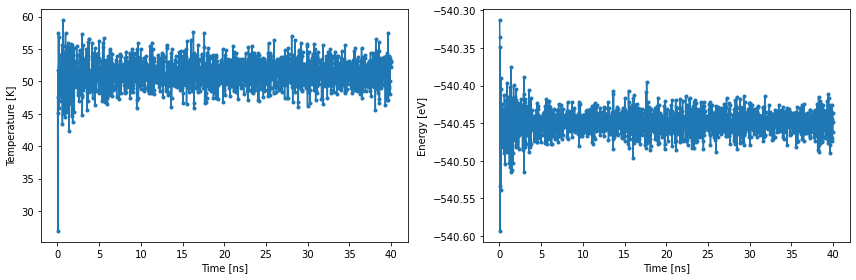

In [34]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(time_array*1e12,Temp_array,'.-')
axs[1].plot(time_array*1e12,energy_array,'.-')

for ax in axs:
    ax.set_xlabel('Time [ns]')

axs[0].set_ylabel('Temperature [K]')
axs[1].set_ylabel('Energy [eV]')

fig.tight_layout()

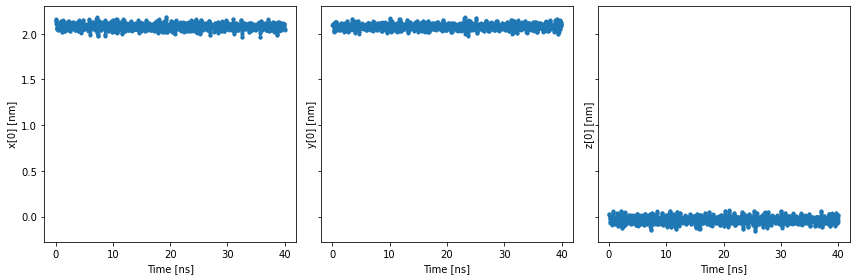

In [35]:
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

axs[0].plot(time_array*1e12,all_x[0],'.-')
axs[1].plot(time_array*1e12,all_y[0],'.-')
axs[2].plot(time_array*1e12,all_z[0],'.-')

for ax in axs:
    ax.set_xlabel('Time [ns]')
    
axs[0].set_ylabel('x[0] [nm]')
axs[1].set_ylabel('y[0] [nm]')
axs[2].set_ylabel('z[0] [nm]')

fig.tight_layout()

### Test zone - used for quick tests and monkey patch